### Arima Time Series Analysis

In this case study example, we will learn about time series analysis for a manufacturing operation. Time series analysis and modeling have many business and social applications. It is extensively used to forecast company sales, product demand, stock market trends, agricultural production etc.

The fundamental idea for time series analysis is to decompose the original time series (sales, stock market trends, etc.) into several independent components. Typically, business time series are divided into the following four components:
    <br> Trend – overall direction of the series i.e. upwards, downwards etc.
    <br>Seasonality– monthly or quarterly patterns
    <br>Cycle – long-term business cycles, they usually come after 5 or 7 years
    <br>Irregular remainder – random noise left after extraction of all the components

Interference of these components produces the final series.
Why bother decomposing the original / actual time series into components? It is much easier to forecast the individual regular patterns produced through decomposition of time series than the actual series.

### Step 0: Problem Definition

PowerHorse, a tractor and farm equipment manufacturing company, was established a few years after World War II. The company has shown a consistent growth in its revenue from tractor sales since its inception. However, over the years the company has struggled to keep it’s inventory and production cost down because of variability in sales and tractor demand. The management at PowerHorse is under enormous pressure from the shareholders and board to reduce the production cost. Additionally, they are also interested in understanding the impact of their marketing and farmer connect efforts towards overall sales. In the same effort, they have hired us as a data science and predictive analytics consultant.

We will develop an ARIMA model to forecast sale / demand of tractor for next 3 years. Additionally, We will also investigate the impact of marketing program on sales by using an exogenous variable ARIMA model.
As a part of this project, one of the production units we are analysing is based in South East Asia. This unit is completely independent and caters to neighbouring geographies. This unit is just a decade and a half old. In 2014 , they captured 11% of the market share, a 14% increase from the previous year. However, being a new unit they have very little bargaining power with their suppliers to implement Just-in-Time (JiT) manufacturing principles that have worked really well in PowerHorse’s base location. Hence, they want to be on top of their production planning to maintain healthy business margins. Monthly sales forecast is the first step we have suggested to this unit towards effective inventory management.

In [2]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from io import StringIO
import requests
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
df = pd.read_csv("Tractor-Sales.csv")
df

,Month-Year,Number of Tractor Sold
0,Jan-03,141
1,Feb-03,157
2,Mar-03,185
3,Apr-03,199
4,May-03,203
...,...,...
139,Aug-14,848
140,Sep-14,640
141,Oct-14,581
142,Nov-14,519


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Month-Year              144 non-null    object
 1   Number of Tractor Sold  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [8]:
dates = pd.date_range(start = "2003-01-01", freq="MS", periods= len(df))
dates

DatetimeIndex(['2003-01-01', '2003-02-01', '2003-03-01', '2003-04-01',
               '2003-05-01', '2003-06-01', '2003-07-01', '2003-08-01',
               '2003-09-01', '2003-10-01',
               ...
               '2014-03-01', '2014-04-01', '2014-05-01', '2014-06-01',
               '2014-07-01', '2014-08-01', '2014-09-01', '2014-10-01',
               '2014-11-01', '2014-12-01'],
              dtype='datetime64[ns]', length=144, freq='MS')

In [9]:
#Breakink down into INDIVIDUAL COMPONENTS (Year, Months, and Date)
import calendar
df["Months"] = dates.month
df["Months"] = df["Months"].apply(lambda x: calendar.month_abbr[x]) #Because of this line we will get(Jan, Feb) instead of (1st, 2nd) month

df["Year"] = dates.year

In [10]:
df.head()

,Month-Year,Number of Tractor Sold,Months,Year
0,Jan-03,141,Jan,2003
1,Feb-03,157,Feb,2003
2,Mar-03,185,Mar,2003
3,Apr-03,199,Apr,2003
4,May-03,203,May,2003


In [11]:
df.drop(["Month-Year"], axis=1, inplace= True)

In [12]:
df.head()

,Number of Tractor Sold,Months,Year
0,141,Jan,2003
1,157,Feb,2003
2,185,Mar,2003
3,199,Apr,2003
4,203,May,2003


In [13]:
#Renaming
df.rename(columns = {"Number of Tractor Sold":"Tractor-Sales"}, inplace= True)

In [14]:
df.head()

,Tractor-Sales,Months,Year
0,141,Jan,2003
1,157,Feb,2003
2,185,Mar,2003
3,199,Apr,2003
4,203,May,2003


In [15]:
#Indexing
df.set_index(dates, inplace=True)
df.head()

,Tractor-Sales,Months,Year
2003-01-01,141,Jan,2003
2003-02-01,157,Feb,2003
2003-03-01,185,Mar,2003
2003-04-01,199,Apr,2003
2003-05-01,203,May,2003


In [16]:
df.columns

Index(['Tractor-Sales', 'Months', 'Year'], dtype='object')

In [18]:
from statsmodels.tsa.stattools import adfuller

In [19]:
X = df["Tractor-Sales"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: 1.108825
p-value: 0.995291
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579
Failed to Reject Ho - Time Series is Non-Stationary


C:\Users\umerb\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Tractor Sales')

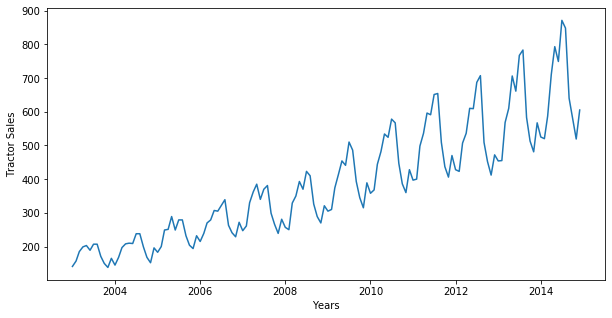

In [12]:
#PLOT
df_ts= df["Tractor-Sales"]
plt.figure(figsize=(10,5))
plt.plot(df_ts)
plt.xlabel("Years")
plt.ylabel("Tractor Sales")

Now we start with time series decomposition of this data to understand underlying patterns such as trend, seasonality, cycle and irregular remainder for tractor sales.
In the above data, a cyclic pattern seems to be non-existent since the unit we are analysing is a relatively new unit to notice business cycles. Also in theory, business cycles in traditional businesses are observed over a period of 7 or more years. Hence, we won’t include business cycles in this time series decomposition exercise. Also, we observe a overall increasing trend across years. We will build our model based on the following function:

### Step 1.1: Trend - Time Series Decomposition

# Determining and Plotting Rolling Statistics

In [13]:
# Determining and Plotting Rolling Statistics
roll_mean = df_ts.rolling(window=12).mean()
roll_std = df_ts.rolling(window=12).std()


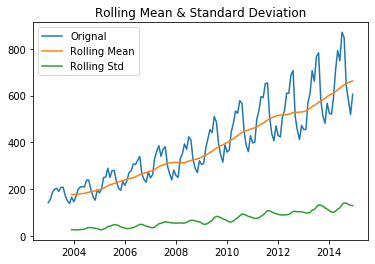

In [14]:
#Plotting Rolling Stats
orig = plt.plot(df_ts, label="Orignal")
mean = plt.plot(roll_mean, label="Rolling Mean")
std = plt.plot(roll_std, label="Rolling Std")
plt.legend(loc="best")
plt.title("Rolling Mean & Standard Deviation")
plt.show()

# Creating PIOVT TABLE for Monthly Basis

In [15]:
monthly_sales = pd.pivot_table(df, values= "Tractor-Sales",columns="Year",index="Months")
monthly_sales

Year,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
Months,,,,,,,,,,,,
Apr,199,208,251,279,362,350,414,482,536,536,610,710
Aug,207,238,279,339,381,410,486,567,654,707,783,848
Dec,165,196,232,272,281,321,389,428,470,472,567,605
Feb,157,168,200,239,261,250,310,368,400,423,455,520
Jan,141,145,183,215,247,257,305,358,397,428,454,525
Jul,207,238,279,322,370,423,510,578,651,687,767,871
Jun,189,209,249,305,340,370,441,524,591,609,661,749
Mar,185,197,249,270,330,329,374,444,498,507,568,587
May,203,210,289,307,385,393,454,534,596,610,706,793


In [16]:
#Re-Index to get it properly ROWwise
monthly_sales= monthly_sales.reindex(index = ['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
monthly_sales

Year,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
Months,,,,,,,,,,,,
Jan,141,145,183,215,247,257,305,358,397,428,454,525
Feb,157,168,200,239,261,250,310,368,400,423,455,520
Mar,185,197,249,270,330,329,374,444,498,507,568,587
Apr,199,208,251,279,362,350,414,482,536,536,610,710
May,203,210,289,307,385,393,454,534,596,610,706,793
Jun,189,209,249,305,340,370,441,524,591,609,661,749
Jul,207,238,279,322,370,423,510,578,651,687,767,871
Aug,207,238,279,339,381,410,486,567,654,707,783,848
Sep,171,199,232,263,299,326,393,447,509,509,583,640


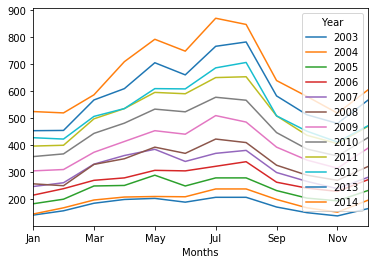

In [17]:
monthly_sales.plot()

# Making yearly data and ploting it to check year patterns Using BOX PLOT


In [18]:
yearly_sales= pd.pivot_table(df, values = "Tractor-Sales", columns = "Months", index = "Year")
yearly_sales

Months,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
Year,,,,,,,,,,,,
2003,199,207,165,157,141,207,189,185,203,138,150,171
2004,208,238,196,168,145,238,209,197,210,152,168,199
2005,251,279,232,200,183,279,249,249,289,194,204,232
2006,279,339,272,239,215,322,305,270,307,229,241,263
2007,362,381,281,261,247,370,340,330,385,239,266,299
2008,350,410,321,250,257,423,370,329,393,270,289,326
2009,414,486,389,310,305,510,441,374,454,315,345,393
2010,482,567,428,368,358,578,524,444,534,360,386,447
2011,536,654,470,400,397,651,591,498,596,406,437,509


In [19]:
#Re-Index to get it properly COLUMNwise
yearly_sales= yearly_sales.reindex(columns = ['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
yearly_sales

Months,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2003,141,157,185,199,203,189,207,207,171,150,138,165
2004,145,168,197,208,210,209,238,238,199,168,152,196
2005,183,200,249,251,289,249,279,279,232,204,194,232
2006,215,239,270,279,307,305,322,339,263,241,229,272
2007,247,261,330,362,385,340,370,381,299,266,239,281
2008,257,250,329,350,393,370,423,410,326,289,270,321
2009,305,310,374,414,454,441,510,486,393,345,315,389
2010,358,368,444,482,534,524,578,567,447,386,360,428
2011,397,400,498,536,596,591,651,654,509,437,406,470


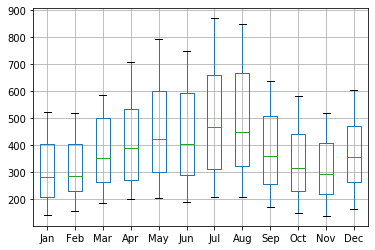

In [20]:
yearly_sales.boxplot()

# Important Inferences



==>The tractor sales have been increasing without fail every year.

==>July and August are the peak months for tractor sales and the variance and the mean value in July and August are also much higher than any of the other months.

==>We can see a seasonal cycle of 12 months where the mean value of each month starts with a increasing trend in the beginning of the year and drops down towards the end of the year.

==>We can see a seasonal effect with a cycle of 12 months.

# Decomposing Time Series

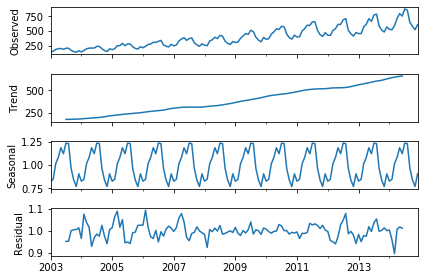

In [21]:
decomp = sm.tsa.seasonal_decompose(df_ts, model="multiplicative")
fig = decomp.plot()

# P,D & Q Parameter

In [22]:
d = q = range(0,2)  #d = No of Non-Seasonal difference needed for stationarity/// q= No of lag/forecast error in the prediction
p = range(0,4)  #Its the No of Autoregressive Term

In [23]:
pdq= list(itertools.product(p,d,q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1),
 (2, 0, 0),
 (2, 0, 1),
 (2, 1, 0),
 (2, 1, 1),
 (3, 0, 0),
 (3, 0, 1),
 (3, 1, 0),
 (3, 1, 1)]

In [24]:
seasonal_pdq = [(x[0],x[1],x[2],12) for x in pdq]
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12),
 (2, 0, 0, 12),
 (2, 0, 1, 12),
 (2, 1, 0, 12),
 (2, 1, 1, 12),
 (3, 0, 0, 12),
 (3, 0, 1, 12),
 (3, 1, 0, 12),
 (3, 1, 1, 12)]

In [25]:
#Examples of parameters combinations for Seasonal ARIMA
print("ARIMAX: {} X {}".format(pdq[1],seasonal_pdq[1]))

ARIMAX: (0, 0, 1) X (0, 0, 1, 12)


# Building SARIMAX model & Finding the MINIMUM value for AIC(Akaike Information Criterion)
AIC estimates the quality of each model, relative to each of the other models. Thus, AIC provides a means for model selection.

In [26]:
warnings.filterwarnings("ignore") #Specify to ignore warning messages
AIC = [] #Alkaline Information Curve==> It define accuracy of DATA and how to predict the future data
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_ts,
                                           order=param,
                                           seasonal_order=param_seasonal) 
            results = mod.fit()
            
            print("SARIMAX{}x{} = AIC:{}".format(param, param_seasonal, results.aic), end="\r" )
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue
            

In [27]:
#SMALLEST AIC
print("The smallest AIC {} for model SARIMAX {} x {}".format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

The smallest AIC 799.9064282670552 for model SARIMAX (3, 1, 0) x (3, 1, 1, 12)


In [28]:
SARIMAX_model[AIC.index(min(AIC))][0]

(3, 1, 0)

In [29]:
min(AIC)

799.9064282670552

In [30]:
AIC.index(min(AIC))

239

In [31]:
SARIMAX_model[239]

[(3, 1, 0), (3, 1, 1, 12)]

In [32]:
SARIMAX_model[239][0]

(3, 1, 0)

In [33]:
SARIMAX_model[239][1]

(3, 1, 1, 12)

# ==>

In [34]:
mod = sm.tsa.statespace.SARIMAX(df_ts,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

In [35]:
#FITTING THE MODEL
results = mod.fit()

# DIGNOSTIC PLOT

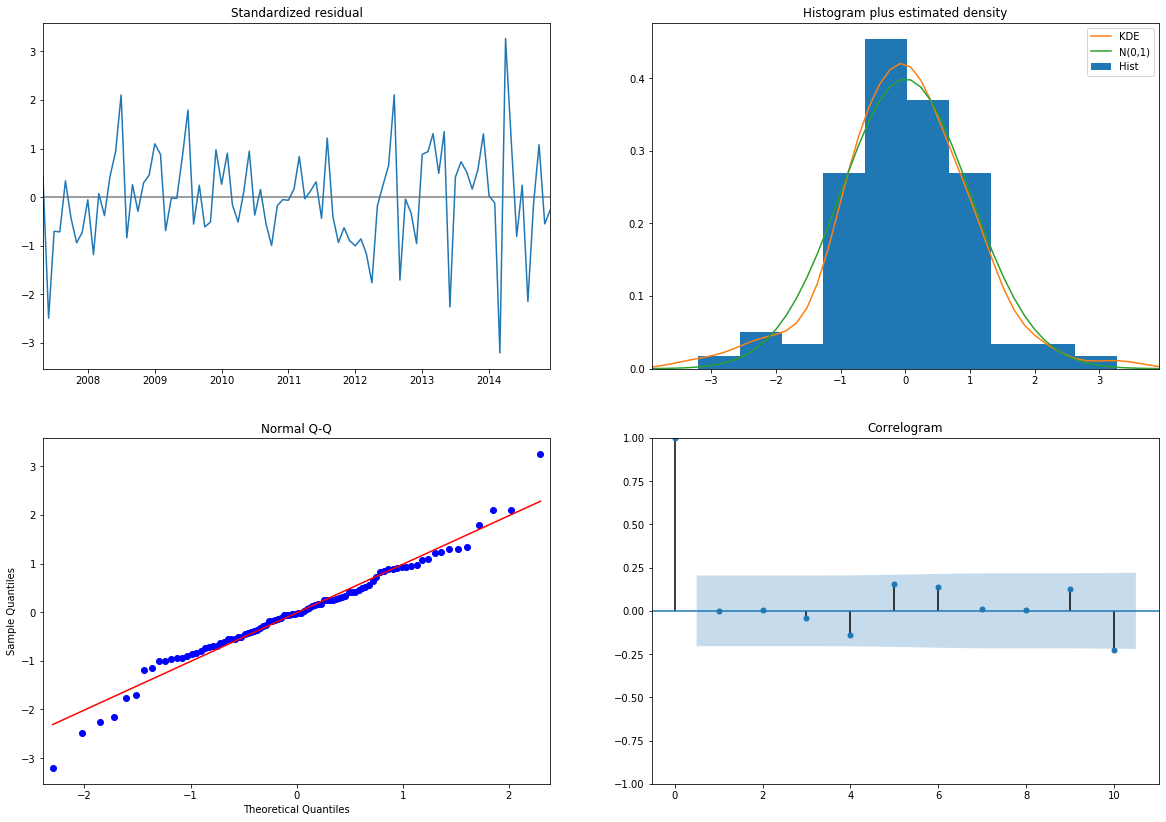

In [36]:

results.plot_diagnostics(figsize=(20, 14))
plt.show()

# PREDICTIONS

In [37]:
#In this case the model is used to predict data that the model was built on. 
#1-step ahead forecasting implies that each forecasted point is used to predict the following one.
pred0 = results.get_prediction(start='2003-01-01', dynamic=False)
pred0_ci = pred0.conf_int()

In [38]:
#In sample prediction with dynamic forecasting of the last year  
#Again, the model is used to predict data that the model was built on.
pred1 = results.get_prediction(start='2003-01-01', dynamic=True)
pred1_ci = pred1.conf_int()

In [39]:
#"True" forecasting of out of sample data. 
#In this case the model is asked to predict data it has not seen before.
pred2 = results.get_forecast('2016-01-01')
# Give the end year till you want forecast
pred2_ci = pred2.conf_int()

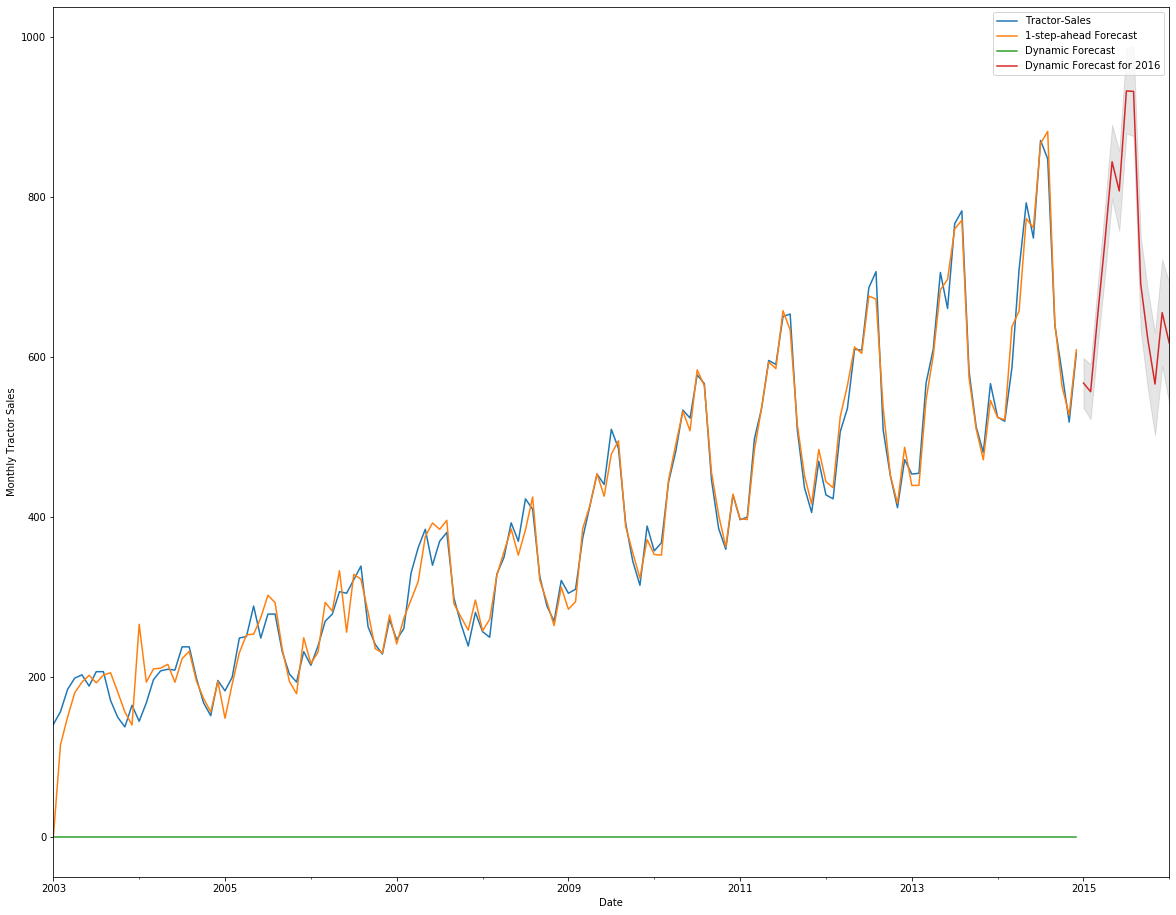

In [40]:
#Plot the predicted values
ax = df_ts.plot(figsize=(20, 16))
pred0.predicted_mean.plot(ax=ax, label='1-step-ahead Forecast')
pred1.predicted_mean.plot(ax=ax, label='Dynamic Forecast')
pred2.predicted_mean.plot(ax=ax, label='Dynamic Forecast for 2016')
ax.fill_between(pred2_ci.index, pred2_ci.iloc[:, 0], pred2_ci.iloc[:, 1], color='k', alpha=.1)
plt.ylabel('Monthly Tractor Sales')
plt.xlabel('Date')
plt.legend()
plt.show()


In [41]:
pred1

In [42]:
pred2_ci.head()

,lower Tractor-Sales,upper Tractor-Sales
2015-01-01,536.514077,598.976753
2015-02-01,522.616479,591.270509
2015-03-01,615.317273,692.030008
2015-04-01,701.791441,787.941251
2015-05-01,797.905315,890.760522


In [43]:
pred2_ci.iloc[:, 0].head()

2015-01-01    536.514077
2015-02-01    522.616479
2015-03-01    615.317273
2015-04-01    701.791441
2015-05-01    797.905315
Freq: MS, Name: lower Tractor-Sales, dtype: float64

In [44]:
pred2_ci.iloc[:, 1].head()

2015-01-01    598.976753
2015-02-01    591.270509
2015-03-01    692.030008
2015-04-01    787.941251
2015-05-01    890.760522
Freq: MS, Name: upper Tractor-Sales, dtype: float64

In [45]:
pred2_ci.index

DatetimeIndex(['2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01'],
              dtype='datetime64[ns]', freq='MS')